# Benchmark C1.1: Coupled problems - Water uptake by a single root
by Andrea Schnepf, Daniel Leitner

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from van_genuchten import *

## Theory for the 1D radially symmetric problem

This benchmark follows the paper of Schröder et al. (2008). It is based on the analytical solutions of the 1D radially symmetric problem of water uptake by a single root. Based on the steady-rate assumption and using the matric flux potential (cm$^2$ day$^{-1}$)
$$
\Phi(h_c)=\int_{-\infty}^{h_c}  K(h) dh
$$
that linearizes the Richards equation. The radial pressure head profiles for non-stressed and stressed conditions can be calculated from the anaylic solution of the matric flux potential around the root, given by
$$
\Phi(r)=\Phi_{r_{out}} + (q_{root}r_{root}-q_{out}r_{out})\left[ \frac{r^2/r_{root}^2}{2(1-\rho^2)} + \frac{\rho^2}{1-\rho^2}\left(\text{ln}  \frac{r_{out}}{r}-\frac{1}{2} \right) \right] + q_{out}r_{out} \text{ln} \frac{r}{r_{out}}
$$
(non-stressed), and 
$$
\Phi(r) = \left(\Phi_{r_{out}} - \Phi_{r_{root}} + q_{out}r_{out}\text{ln} \frac{1}{\rho}\right)\frac{r^2/r_{root}^2 - 1 + 2\rho^2 \text{ln}  r_{root}/r}{\rho^2 -1 + 2\rho^2 ln 1/\rho} + q_{out}r_{out}\text{ln} \frac{r}{r_{root}} + \Phi_{root},
$$
(stressed), where $\rho=\frac{r_{out}}{r_{root}}$.

Given the pressure head at the outer boundary, the solution computes the pressure head profile towards the root. Due to the steady-rate assumption, the problem has become a stationary boundary value problem. However, under non-stressed conditions, we can calculate the time that corresponds to a given radial pressure head profile by dividing the volume of water removed from the soil domain by the known water flow rate. The water remaining in a 1 cm high hollow cylinder around the root is given by 
$$
V = \int_0^{2\pi} \int_{r_{root}} ^{r_{out}} r \theta dr d\phi.
$$ 

The initially available water volume in the soil domain is given by 
$$
V_i = (r_{out}^2-r_{root}^2) \pi \theta_{initial}.
$$ 

Thus, the corresponding time at which a given radial profile is reached is given by 
$$
t =\frac{(V_i-V)}{2 r_{root} \pi q_{root}}.
$$

## Description of benchmark C1.1

A straight vertical root of 1 cm length is positioned in the center of this soil domain. A constant transpiration $q_r$ is predetermined. Aim of the benchmark is to analyze water depletion from soil and we compare the time when the root reaches the plants wilting point (-15000 cm)

The flux boundary condition of the benchmark ($q_r$ is given in cm$^3$cm$^{-2}d^{-1}$) needs to be converted to the volumetric water flow rate that is prescribed as the boundary condition at the root collar, i.e., $Q_x|_{collar} = 2 r_{root} \pi q_r l$. The root hydraulic properties are chosen large enough so that the root is not limiting water and the root collar pressure translates quickly to each root segment

The volume of the soil domain $V_s$ is equal to the volume of the extruded radial geometry of the reference solution, i.e., 
$$
V_s = (r_{out}^2-r_{root}^2)\pi l.$$ 
Thus, for a root of length $l=1$cm, the soil domain has size 
$$
l\times w \times d  =\sqrt{r_{out}^2-r_{root}^2 \pi} \sqrt{r_{out}^2-r_{root}^2 \pi} (1 \textrm{cm}^3). 
$$ 

Soil properties are described by the van Genuchten model (Van Genuchten, 1980). Following Vanderborght et al. (2005), we choose three types of soil with parameters $\theta_r$, $\theta_s$, $\alpha$, $n$, $K_s$, and $l$ given by:

In [2]:
sand = Parameters(0.045, 0.43, 0.15, 3, 1000) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50) 
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10) 

### Computation of the analytical solutions

We use the analytical solution of the steady rate approximation (see Schröder et al. 2008) to benchmark the simulators.

We calculate the solution for  for all combinations of soil and transpiration scenarios.
The two constant transpiration scenarios are: *high* 0.1 cm/day and *low* 0.05 cm/day. 

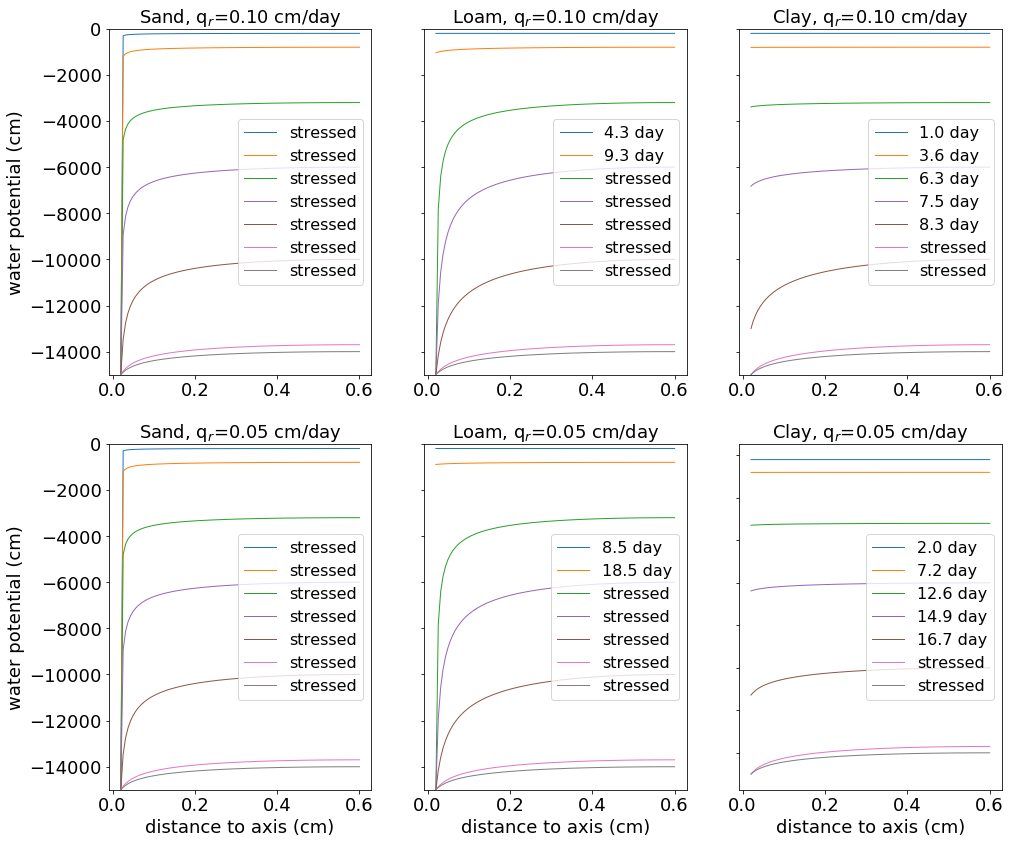

In [5]:
r_root = 0.02 # cm
r_out = 0.6 # cm, value according to Jorda Guerra et al. (2019)
rho = r_out/r_root
h_out = [-200, -800, -3200, -6000,-10000,-13700, -14000] # cm
h_lim = -15000 # cm
q_out = 0 # otherwise, q_root * (r_root/(2*r_out))

fig, ax = plt.subplots(2, 3,figsize=(16, 14))
soils=["Sand", "Loam", "Clay"]

h_stressonset=[]
r = np.linspace(r_root, r_out, 100)
for s,soil in enumerate([sand, loam, clay]): 
    for q,q_root in enumerate([0.1,0.05]): # q_root in [cm/day], high and low transpiration        
        cc = 0 # start with dark color
        crit = 0
        for k in range(len(h_out)):
            MFP_nostress = MFP(h_out[k],soil) + (q_root*r_root-q_out*r_out)*(r**2/r_root**2/(2*(1-rho**2))+rho**2/(1-rho**2)*(np.log(r_out/r)-0.5)) + q_out*r_out*np.log(r/r_out)
            MFP_stress  = (MFP(h_out[k],soil)+q_out*r_out*np.log(1/rho))*( (r**2/r_root**2 - 1 + 2*rho**2*np.log(r_root/r))/(rho**2 - 1+2*rho**2*np.log(1/rho)) ) + q_out*r_out*np.log(r/r_root)
            h_radial = np.zeros(len(r)) 
            wc_radial = np.zeros(len(r))
            if np.amin(MFP_nostress)>0: # no stress    
                for i in range(len(r)):
                    h_radial[i] = h(MFP_nostress[i],soil)
                    wc_radial[i] = water_content(h_radial[i],soil)
            else: # stress
                for i in range(len(r)):        
                    h_radial[i] = h(MFP_stress[i],soil)
                    wc_radial[i] = water_content(h_radial[i],soil)   
            Q = np.trapz(wc_radial*r,r)
            if np.amin(MFP_nostress)>0: # no stress
                simtime=((r_out**2-r_root**2)*3.14*water_content(-100,soil) - Q*2*3.14)/(2*r_root*3.14*q_root)
                ax[q,s].plot(r, h_radial, label="{:.1f}".format(simtime) + ' day', color = col[cc], alpha = 1, linewidth = 1)
            else:
                ax[q,s].plot(r,h_radial,label='stressed', color = col[cc], alpha = 1, linewidth = 1)
            ax[1,s].set_xlabel("distance to axis (cm)")
            ax[q,0].set_ylabel("water potential (cm)")
            ax[q,1].set_yticklabels([])
            ax[q,2].set_yticklabels([])
            ax[q,s].set_ylim(-15000,0)
            ax[q,s].legend(loc="center right")
            ax[q,s].title.set_text(soils[s]+r', q$_{r}$='+"{:.2f}".format(q_root)+" cm/day")
            cc += 1
            
plt.axis('tight')
plt.savefig('c11.png', dpi=300, bbox_inches = "tight")

## References

Schröder, T., Javaux, M., Vanderborght, J., Korfgen, B., and Vereecken, H. (2008). Effect of local soil hydraulic conductivity drop using a three-dimensional root water uptake model. *Vadose Zone Journal*, 7(3), 1089-1098.